### Data Curation

Dataset: https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Hugging Face folder: https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [1]:
## imports
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")

In [3]:
%matplotlib inline

In [4]:
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
dataset = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",
    f"raw_meta_Appliances", 
    split="full",
    trust_remote_code=True
    )

In [6]:
print(f"Number of Appliances: {len(dataset)}")

Number of Appliances: 94327


## Step 1: Investigate

In [7]:
## investigate a datapoint
datapoint = dataset[0]
datapoint

{'main_category': 'Industrial & Scientific',
 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)',
 'average_rating': 3.7,
 'rating_number': 61,
 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food',
  '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like',
  '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take 

In [8]:
datapoint.keys()

dict_keys(['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'])

In [9]:
# investigate
print(datapoint["title"])
print()
print(datapoint["description"])
print()
print(datapoint["features"])
print()
print(datapoint["details"])
print()
print(datapoint["price"])

ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)

[]

['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out and make you cool', '【Full Monitoring】 Designed with compressor cooling system, operates at low noise and wil

In [10]:
## how many of the products have a price?
prices = 0
for datapoint in dataset:
    price = datapoint["price"]
    if price is not None and price != "None" and float(price) >0 :
        try:
            if float(price) > 0:
                prices += 1
        except (ValueError, TypeError):
            continue
    else:
        continue

print(f"Number of products with a price: {prices:,} with a completion rate of {100*prices/len(dataset):.2f}%")

Number of products with a price: 46,726 with a completion rate of 49.54%


In [11]:
## for the avialable products with price, gather the price and length

prices = []
lengths = []

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except (ValueError, TypeError):
        pass

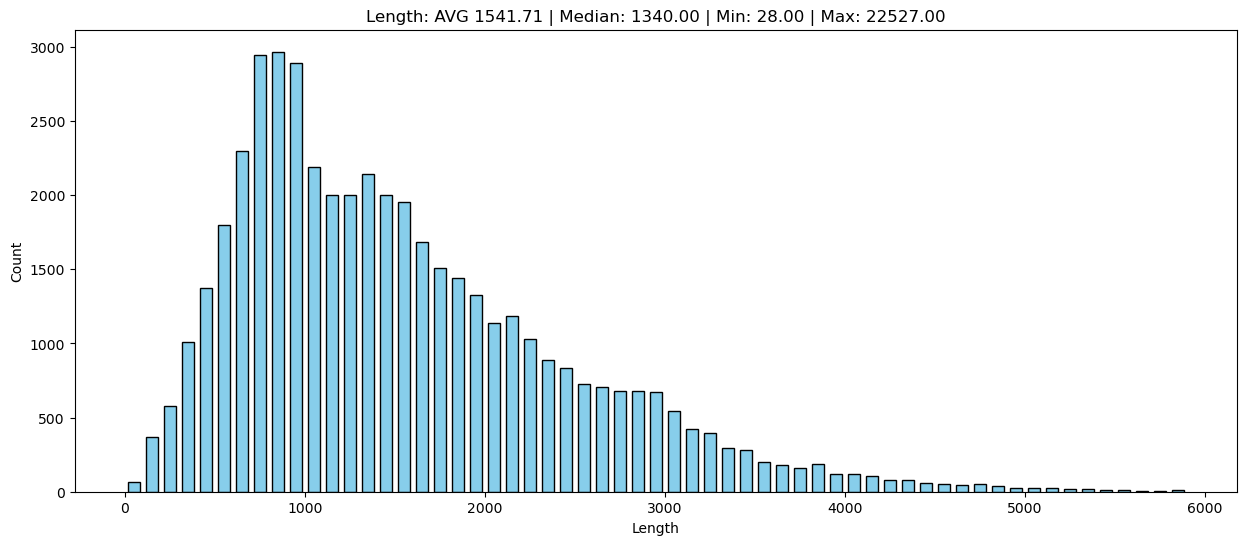

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title(f"Length: AVG {sum(lengths)/len(lengths):.2f} | Median: {sorted(lengths)[len(lengths)//2]:.2f} | Min: {min(lengths):.2f} | Max: {max(lengths):.2f}")
plt.xlabel("Length")
plt.ylabel("Count")
plt.hist(lengths, rwidth=0.7, color='skyblue', edgecolor='black', bins=range(0, 6000, 100))
plt.show()



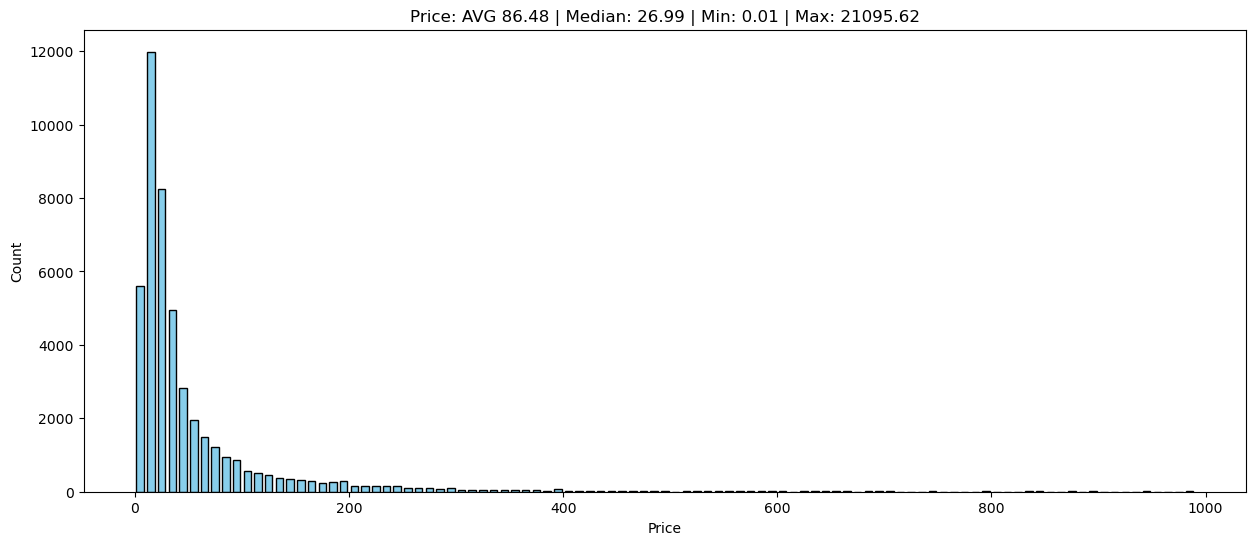

In [13]:
## plot distrubution of the price
plt.figure(figsize=(15, 6))
plt.title(f"Price: AVG {sum(prices)/len(prices):.2f} | Median: {sorted(prices)[len(prices)//2]:.2f} | Min: {min(prices):.2f} | Max: {max(prices):.2f}")
plt.hist(prices, rwidth=0.7, color='skyblue', edgecolor='black', bins=range(0, 1000, 10))
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [14]:
## what is the item that costs over 21k dollars!
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000 and price is not None and price != "None":
            print(f"Name of the product: {datapoint['title']} | Price: {price}")
    except (ValueError, TypeError):
        pass

Name of the product: TurboChef BULLET Rapid Cook Electric Microwave Convection Oven | Price: 21095.62


## Step 2. Curate the dataset

In [15]:
from items import Item

In [16]:
## create an Item object for each datapoint
items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price>0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except Exception as e:
        pass

In [17]:
## look at the first item
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [21]:
## investigate the prompt that will be used for training
print(items[0].prompt)

How much does it cost to the nearest dollar?

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces
 PARTS NUMBER The dishwasher top rack wheels and stud assembly Kit （4 pcs） SCOPE OF APPLICATION The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART FIXES SYMPTOMS Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure QUALITY WARRANTY The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund Brand Name AMI PARTS, Model

Price is $9.00




In [20]:
## looking at the prompt for the same item for testing
print(items[0].test_prompt())

How much does it cost to the nearest dollar?

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces
 PARTS NUMBER The dishwasher top rack wheels and stud assembly Kit （4 pcs） SCOPE OF APPLICATION The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART FIXES SYMPTOMS Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure QUALITY WARRANTY The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund Brand Name AMI PARTS, Model

Price is $


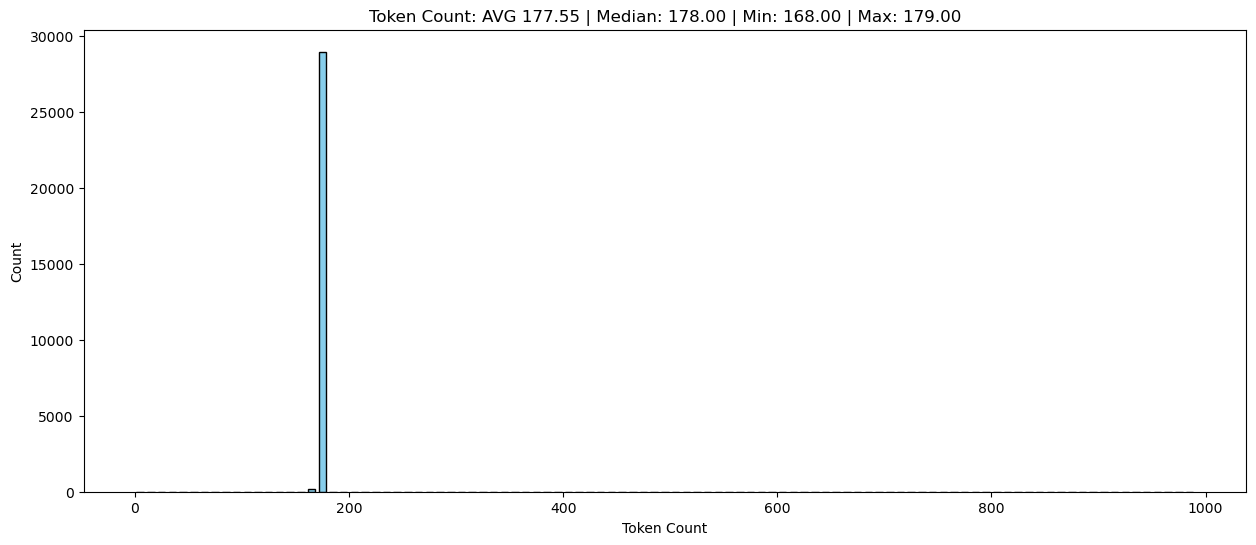

In [23]:
## plot the distribution of the token counts
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token Count: AVG {sum(tokens)/len(tokens):.2f} | Median: {sorted(tokens)[len(tokens)//2]:.2f} | Min: {min(tokens):.2f} | Max: {max(tokens):.2f}")
plt.xlabel("Token Count")
plt.ylabel("Count")
plt.hist(tokens, rwidth=0.7, color='skyblue', edgecolor='black', bins=range(0, 1000, 10))
plt.show()